In [1]:
import sys
sys.path.append('../')
import libs.db
import libs.prep_df
import pandas as pd
import sqlite3

In [2]:
tickers = libs.db.get_tickers("sp10.csv")
num_ticks = 60

In [3]:
sql_file = "sp10_historical.db"
conn = libs.db.create_connection(sql_file)
hist_df = libs.db.df_from_db(conn)
libs.db.close_connection(conn)
hist_df = libs.prep_df.normalize_df(hist_df)

In [4]:
hist_shifted_df = pd.DataFrame()
for ticker in tickers:
    hist_shifted_df[ticker] = hist_df[ticker].copy()
    for i in range(1,num_ticks):
        name = f"{ticker}-{i}"
        hist_shifted_df[name] = hist_df[ticker].shift(i)
hist_shifted_df = hist_shifted_df.copy()
hist_shifted_df.shape

ipykernel_launcher:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
ipykernel_launcher:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


(17080, 600)

In [5]:
hist_pct_returns_df_list = []
for ticker in tickers:
    name = f"{ticker}_Buy"
    returns_df = pd.DataFrame()
    returns_df[name] = hist_df[ticker].pct_change(periods=16).shift(-16).apply(lambda x : 1 if x >= 0.0075 else 0)
    hist_pct_returns_df_list.append(returns_df)
len(hist_pct_returns_df_list)

10

In [6]:
sql_file = "sp10_current.db"
conn = libs.db.create_connection(sql_file)
current_df = libs.db.df_from_db(conn)
libs.db.close_connection(conn)
current_df = libs.prep_df.normalize_df(current_df)

In [7]:
current_shifted_df = pd.DataFrame()
for ticker in tickers:
    current_shifted_df[ticker] = current_df[ticker].copy()
    for i in range(1,num_ticks):
        name = f"{ticker}-{i}"
        current_shifted_df[name] = current_df[ticker].shift(i)
current_shifted_df = current_shifted_df.copy()
current_shifted_df.dropna(inplace=True)

ipykernel_launcher:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
ipykernel_launcher:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [8]:
hist_pctchange_df = hist_shifted_df.pct_change()
hist_pctchange_df = pd.concat([hist_pctchange_df, *hist_pct_returns_df_list], axis=1)
hist_pctchange_df.dropna(inplace=True)
hist_pctchange_df.shape

(17020, 610)

In [9]:
current_pctchange_df = current_shifted_df.pct_change()
current_pctchange_df.dropna(inplace=True)

In [10]:
y_start = len(tickers)*num_ticks

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [12]:
X = hist_pctchange_df.iloc[:,0:y_start].values
y = []
for i in range(0,len(tickers)):
    y.append(hist_pctchange_df.iloc[:,y_start+i].values)

In [13]:
gb_models = []
gb_confusion = []
gb_classification = []
target_names = ["Not Buy", "Buy"]
for i in range(0,len(tickers)):
    ticker = tickers[i]
    model = GradientBoostingClassifier(n_estimators=20,
                                        learning_rate=0.75,
                                        max_features=5,
                                        max_depth=3,
                                        random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y[i],random_state=1,stratify=y[i])
    model.fit(X_train,y_train)
    gb_models.append(model)
    predicted = model.predict(X_test)
    gb_confusion.append(confusion_matrix(y_test, predicted))
    gb_classification.append(classification_report(y_test, predicted, target_names=target_names))
    print("--------------------------------------")
    print(ticker)
    print(f"Training Data Score: {model.score(X_train, y_train)}")
    print(f"Testing Data Score: {model.score(X_test, y_test)}")
    print(gb_confusion[i])
    print(gb_classification[i])


--------------------------------------
AAPL
Training Data Score: 0.7086564825695261
Testing Data Score: 0.6695652173913044
[[2728  171]
 [1235  121]]
              precision    recall  f1-score   support

     Not Buy       0.69      0.94      0.80      2899
         Buy       0.41      0.09      0.15      1356

    accuracy                           0.67      4255
   macro avg       0.55      0.52      0.47      4255
weighted avg       0.60      0.67      0.59      4255

--------------------------------------
MSFT
Training Data Score: 0.7281629455542499
Testing Data Score: 0.69048178613396
[[2809  172]
 [1145  129]]
              precision    recall  f1-score   support

     Not Buy       0.71      0.94      0.81      2981
         Buy       0.43      0.10      0.16      1274

    accuracy                           0.69      4255
   macro avg       0.57      0.52      0.49      4255
weighted avg       0.63      0.69      0.62      4255

--------------------------------------
AMZN
Trai

In [14]:
#Predict pct-change for each of the tickers over the month of June 2021
y_current_predicted = []
current_returns_df_list = []
X = current_pctchange_df.values
for i in range(0,len(tickers)):
    ticker = tickers[i]
    model = gb_models[i]
    predicted = model.predict(X)
    y_current_predicted.append(predicted)
    return_df = pd.DataFrame({"timestamp":current_pctchange_df.index, "buy_predicted": predicted})
    return_df = return_df.set_index("timestamp")
    return_df = return_df.merge(current_df[ticker], how="left", on="timestamp")
    print(ticker, return_df["buy_predicted"].sum())

    money = 10000
    num_shares = 0
    state = 0
    buy_index = 0
    money_list=[]

    for i in range(0,len(return_df)):
        if state == 1 and i == buy_index + 16:
            #sell
            price = return_df.iloc[i,1]
            money = num_shares * price
            state = 0
            print(f"sell {ticker}", i ,price)

        if return_df.iloc[i,0] == 1 and state == 0 and i < len(return_df) - 16:
            #buy
            price = return_df.iloc[i,1]
            num_shares = money / price
            buy_index = i
            state = 1
            print(f"buy {ticker}", i, price)

        if return_df.iloc[i,0] == 1 and state == 1 and i < len(return_df) - 16:
            buy_index = i

        if state == 0 :
            money_list.append(money)
        else:
            price = return_df.iloc[i,1]
            money_list.append(num_shares*price)
    
    return_df["ROI"] = money_list

    current_returns_df_list.append(return_df)

AAPL 1
buy AAPL 185 131.875
sell AAPL 201 134.095
MSFT 1
buy MSFT 168 259.85
sell MSFT 184 263.0
AMZN 3
buy AMZN 115 3380.0
sell AMZN 131 3401.32
buy AMZN 149 3488.0
sell AMZN 165 3496.0
buy AMZN 183 3463.06
sell AMZN 199 3510.0
FB 3
buy FB 18 337.03
sell FB 44 333.08
buy FB 94 335.3904
sell FB 110 337.3
GOOGL 0
TSLA 15
buy TSLA 19 600.0
sell TSLA 40 604.15
buy TSLA 41 603.4801
sell TSLA 58 608.77
buy TSLA 140 614.9397
sell TSLA 161 622.0
buy TSLA 174 628.24
sell TSLA 190 625.84
buy TSLA 211 663.0
sell TSLA 235 679.1851
buy TSLA 256 688.19
sell TSLA 273 680.5
BRK.B 0
NVDA 24
buy NVDA 8 705.3
sell NVDA 32 697.2
buy NVDA 38 697.5
sell NVDA 54 690.12
buy NVDA 82 713.0
sell NVDA 98 719.88
buy NVDA 101 720.0
sell NVDA 126 707.93
buy NVDA 128 709.8
sell NVDA 144 749.0
buy NVDA 174 731.3227
sell NVDA 260 800.0
JPM 2
buy JPM 121 153.5325
sell JPM 137 154.91
buy JPM 180 150.71
sell JPM 196 152.49
JNJ 1
buy JNJ 28 162.56
sell JNJ 44 165.2499


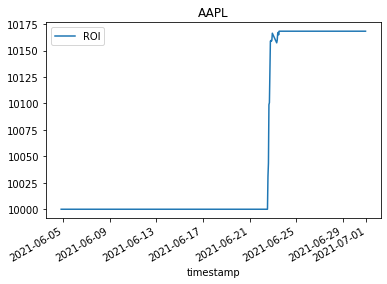

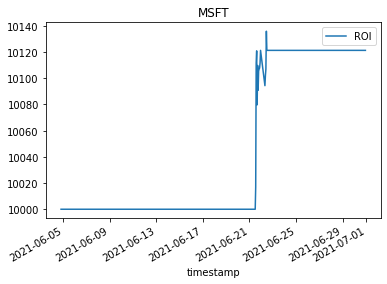

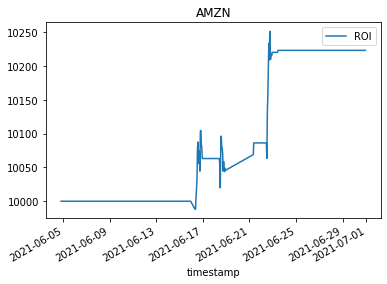

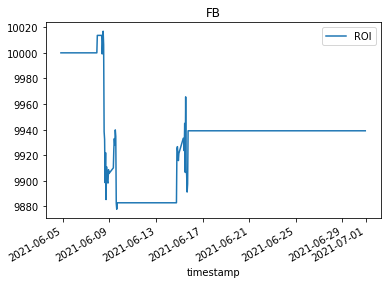

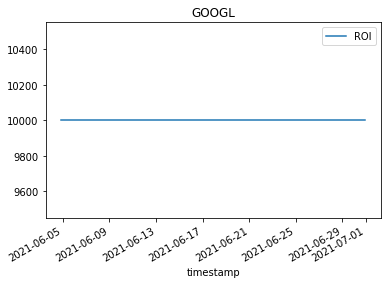

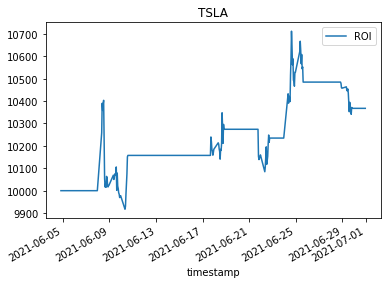

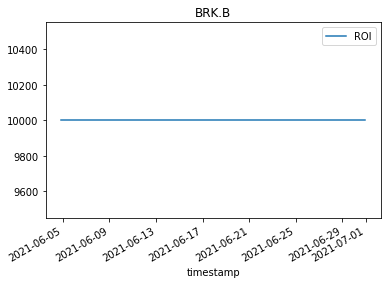

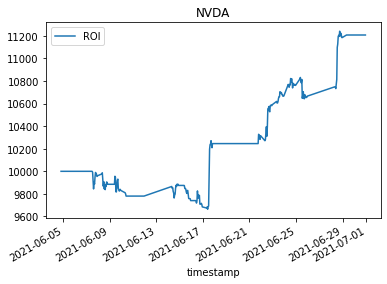

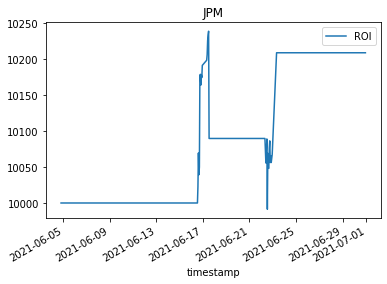

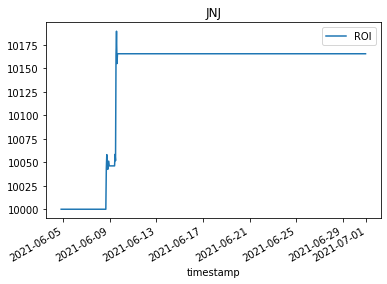

In [15]:
for i in range(0,len(tickers)):
    ticker = tickers[i]
    current_returns_df_list[i].plot(y="ROI", title=ticker)

In [16]:
starting_amount = 10000*len(tickers)
ending_amount = 0
for i in range(0,len(tickers)):
    ending_amount += current_returns_df_list[i].iloc[-1,-1]
ending_amount

102401.12307121852

In [17]:
print("TOTAL BUY SIGNALS------------")
for i in range(0,len(tickers)):
    print(f"{tickers[i]}: {current_returns_df_list[i]['buy_predicted'].sum()}")

TOTAL BUY SIGNALS------------
AAPL: 1
MSFT: 1
AMZN: 3
FB: 3
GOOGL: 0
TSLA: 15
BRK.B: 0
NVDA: 24
JPM: 2
JNJ: 1


In [18]:
summary_df = current_returns_df_list[0].copy()
summary_df = pd.DataFrame(summary_df["ROI"])
summary_df = summary_df.rename(columns={"ROI": f"GRAD_{tickers[0]}"})
for i in range(1,len(tickers)):
    temp_df = current_returns_df_list[i].copy()
    temp_df = pd.DataFrame(temp_df["ROI"])
    temp_df = temp_df.rename(columns={"ROI": f"GRAD_{tickers[i]}"})
    summary_df = pd.concat([summary_df, temp_df], axis=1)
summary_df.to_csv("grad_roi.csv")